# cMyBP-C phosphorylation states as optimization problem (tQSSA model)

This notebook performs the optimization procedure for the results shown in Figure 4C and Figures S23 - S27 of the publication:

Thomas Kampourakis, Saraswathi Ponnam, Daniel Koch (2023):
The cardiac myosin binding protein-C phosphorylation state as a function of multiple protein kinase and phosphatase activities 
Preprint available under: https://doi.org/10.1101/2023.02.24.529959 

Note that the files '**fittedEnzymeConcentrations_Copeland_DonorHearts_tQSSA.npy**' and '**fittedEnzymeConcentrations_Copeland_FailingHearts_tQSSA.npy**' (which are generated by the notebooks '**Fitting_Copeland_Donor_tQSSA.ipynb**' and '**Fitting_Copeland_HF_tQSSA.ipynb**') need to be in the subfolder '**\results**' relative to this file, that the file '**cMyBPC_FinalModelForOptimization_tQSSA.cps**' is required to be in the same folder as this notebook and that the file '**\parametersets\paramset_final_tQSSA.npy** needs to be in the parent folder.

The final figures in the paper are generated by the script '**data_analysis_Copeland_and_optimization.py**'.

## Load model, load parameters, define functions etc

In [8]:
from basico import *
import sys
%pylab
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
if not '../..' in sys.path:
    sys.path.append('../..')

import os
fileDirectory = os.path.abspath('')
path_paramsets = os.path.join(os.path.split(fileDirectory)[0], 'parametersets') 
path_results = os.path.join(fileDirectory, 'results') 

# Load fitted parametersets for PKA, PP1, PP2A
paramset = np.load(os.path.join(path_paramsets, 'paramset_final_tQSSA.npy'))
    
load_model('cMyBPC_FinalModelForOptimization_tQSSA.cps')

# Add measured PKC params
pkc_Kms = np.linspace(3.167e-6,	7.537e-6,4)
pkc_kcat = (5.053+5.262)/2
paramset[:,42] = pkc_Kms[0]
paramset[:,45] = pkc_Kms[1]
paramset[:,48] = pkc_Kms[2]
paramset[:,51] = pkc_Kms[3]
paramset[:,[12,15,18,21]] = pkc_kcat

# Print validation outputs?
valChecks = False

if valChecks:
    print(get_parameters())

settingsHJ = {'method': {'name': PE.HOOKE_JEEVES, 'Iteration Limit':50,'Tolerance':1e-05, 'Rho':0.2}}
settingsGA= {'method': {'name': PE.GENETIC_ALGORITHM, 'Number of Generations':200,'Population Size':20}}

set_opt_settings(settings=settingsHJ)

# Parameter names in Copasi model which are not to be estimated
paramNames = []
for i in range(1,31):
    paramNames.append('k'+str(i))
for i in range(1,31):
    paramNames.append('K'+str(i))
    
p_app = ['k2f','K2f','kisoF','kisoR','k3f','K3f']
for s in p_app: paramNames.append(s)

if valChecks:
    print(paramNames)

cMyBPC_tot = 2e-6
set_species('0P', initial_concentration=cMyBPC_tot)
    
donorValues = np.mean(np.load(os.path.join(path_results,'fittedEnzymeConcentrations_Copeland_DonorHearts_tQSSA_'+str(np.format_float_scientific(cMyBPC_tot, unique=False, precision=2))+'.npy'))[:,2:],axis=0) 
hfValues = np.mean(np.load(os.path.join(path_results,'fittedEnzymeConcentrations_Copeland_FailingHearts_tQSSA_'+str(np.format_float_scientific(cMyBPC_tot, unique=False, precision=2))+'.npy'))[:,2:],axis=0) 

Using matplotlib backend: QtAgg
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [9]:
from tqdm import tqdm

def runOptimization(paramset,pNames,emax,emin,estart,PPtot, n_s, check=False):

    optExpression = ['0P_rel','A_rel','AB_rel','ABC_rel','D_rel','AD_rel','ABD_rel','4P_rel'] # '0PX_rel','AX_rel','ABX_rel','ABCX_rel'
    
    pka_max, rsk2_max, pkc_max, pp1_max = emax
    pka_min, rsk2_min, pkc_min, pp1_min = emin
    pka_start, rsk2_start, pkc_start, pp1_start = estart
    
    n_p = shape(paramset)[0]

    resultVec = []

    optParams = [{'name': 'Values[PKA].InitialValue',
      'lower': pka_min,
      'upper': pka_max,
      'start': pka_start},
     {'name': 'Values[RSK2].InitialValue',
      'lower': rsk2_min,
      'upper': rsk2_max,
      'start': rsk2_start},
     {'name': 'Values[PKC].InitialValue',
      'lower': pkc_min,
      'upper': pkc_max,
      'start': pkc_start},
     {'name': 'Values[PP1].InitialValue',
      'lower': pp1_min,
      'upper': pp1_max,
      'start': pp1_start},
    {'name': 'Values[PPase_tot].InitialValue',
      'lower': PPtot,
      'upper': PPtot,
      'start': PPtot}]
    
    set_opt_parameters(optParams)
    
    for i in tqdm(optExpression):
        set_objective_function(expression='Values['+i+']', minimize=False)
        for p in range(n_p):
            for pn in range(len(pNames)):
                set_parameters(name= pNames[pn], initial_value = paramset[p,2+pn], value = paramset[p,2+pn])
                #set RSK2 params (same for all paramsets)
                set_parameters(name= 'k31', initial_value = 1.8, value = 1.8)
                set_parameters(name= 'k32', initial_value = 1.8, value = 1.8)
                set_parameters(name= 'K31', initial_value = 1.3e-6, value = 1.3e-6)
                set_parameters(name= 'K32', initial_value = 1.3e-6, value = 1.3e-6)

            for ii in range(n_s):
                result = run_optimization()
                resultVec.append(np.hstack((np.asarray(get_opt_statistic()['obj']),np.asarray(result["sol"]))))
    
    return resultVec

def bestRep(a,dims,newdims):
    
    b = np.asarray(a)                            
    b = np.reshape(b,dims)
    c = np.zeros(newdims)

    for i in range(newdims[0]):
        for ii in range(newdims[1]):
            for iii in range(newdims[2]):
                for iv in range(newdims[3]):
                    idx = np.argmax(b[i,ii,iii,iv,:,0])
                    c[i,ii,iii,iv,:] = b[i,ii,iii,iv,idx,:]
    return c

## Some general settings

In [10]:
f1 = 10 # assumed factor by which maximum PKA activity is larger than baseline PKA activity
f2 = hfValues[0]/donorValues[0] # factor by which maximum PKA activity is assumed to be reduced during HF
f3 =  3/4  # factor by which maximum RSK2 and PKC activity can be further reduced

nparamsets = shape(paramset)[0] #number of parametersets to consider (default: shape(paramset)[0] )
reps = 1 # No of times the optimization algorithm probes the same condition

In [11]:
print(f2)

0.18637165207238876


## Physiological conditions

In [12]:
# Vector for max PKA concentrations to be tested
vPKA = [donorValues[0]*f1]
# Vector for total PPase concentrations to be tested
vPPase = [donorValues[3]]


optResult = []

for i in vPKA:
    for ii in vPPase:   
        
        maxValEnzymes = [i, 2e-7, 2e-7, ii]    #pka_max, rsk2_max, pkc_ma, pp1_max
        minValEnzymes = [0,0,0,0]   #pka_min, rsk2_min, pkc_min, pp1_min
        startValEnzymes = [1e-9,1e-9,1e-9,1e-9]  #pka_start, rsk2_start, pkc_start, pp1_start 
        
        #runOptimization(paramset,pNames,emax,emin,estart,PPtot, n_s, check=False):
        optResult.append(runOptimization(paramset[:nparamsets,:],paramNames,maxValEnzymes,minValEnzymes,startValEnzymes,ii,reps))
        
# optResult dimensions are PKA_max, PPase_tot, Phosphostate, Nr Paramsets, Repetition, Solution vector [optVal,PKA,PKC,RSK2,PP1,PPtot]    

# pick best of reps
dims = (len(vPKA),len(vPPase),8,nparamsets,reps,6)
newdims = (len(vPKA),len(vPPase),8,nparamsets,6)
optResult_healthy = bestRep(optResult,dims,newdims)

100%|██████████| 8/8 [47:10<00:00, 353.79s/it]


In [13]:
np.save('optResult_healthy_tQSSA_'+str(np.format_float_scientific(cMyBPC_tot, unique=False, precision=2))+'.npy',optResult_healthy)

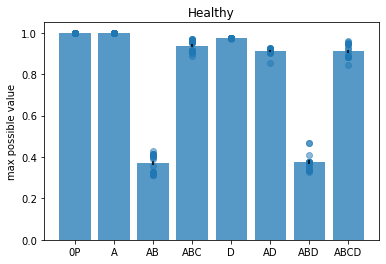

In [14]:
# plot

#optResult_healthy = np.load('optResult_healthy.npy')

y = []
for i in range(8):
    y.append(optResult_healthy[:,:,i,:,0].flatten())

plt.bar(np.asarray(range(8)), np.mean(np.asarray(y),axis=1),yerr=np.std(np.asarray(y),axis=1)/np.sqrt(nparamsets),alpha=0.75)
    
for i in range(8):
    plt.scatter(i*np.ones(len(y[i])),y[i],color='C0',alpha=0.5);
plt.xticks(np.asarray(range(8)),['0P','A','AB','ABC','D','AD','ABD','ABCD']);
plt.ylabel('max possible value');
plt.title('Healthy');

## Heart failure conditions

In [15]:
# Vector for max PKA concentrations to be tested
vPKA = [donorValues[0]*f1*f2]
# Vector for total PPase concentrations to be tested
vPPase = [hfValues[3]]

optResult = []

for i in vPKA:
    for ii in vPPase:   
        
        maxValEnzymes = [i, 2e-7, 2e-7,ii]    #pka_max, rsk2_max, pkc_ma, pp1_max
        minValEnzymes = [0,0,0,0]   #pka_min, rsk2_min, pkc_min, pp1_min
        startValEnzymes = [1e-9,1e-9,1e-9,1e-9]  #pka_start, rsk2_start, pkc_start, pp1_start 
        
        #runOptimization(paramset,pNames,emax,emin,estart,PPtot, n_s, check=False):
        optResult.append(runOptimization(paramset[:nparamsets,:],paramNames,maxValEnzymes,minValEnzymes,startValEnzymes,ii,reps))
        
# optResult dimensions are PKA_max, PPase_tot, Phosphostate, Nr Paramsets, Repetition, Solution vector [optVal,PKA,PKC,RSK2,PP1,PPtot]    

# pick best of reps
dims = (len(vPKA),len(vPPase),8,nparamsets,reps,6)
newdims = (len(vPKA),len(vPPase),8,nparamsets,6)
optResult_HF = bestRep(optResult,dims,newdims)

100%|██████████| 8/8 [46:55<00:00, 351.95s/it]


In [16]:
np.save('optResult_HF_tQSSA_'+str(np.format_float_scientific(cMyBPC_tot, unique=False, precision=2))+'.npy',optResult_HF)

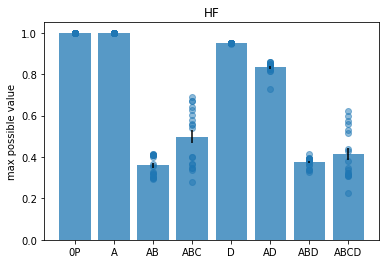

In [17]:
# plot

#optResult_HF = np.load('optResult_HF.npy')

y = []
for i in range(8):
    y.append(optResult_HF[:,:,i,:,0].flatten())

plt.bar(np.asarray(range(8)), np.mean(np.asarray(y),axis=1),yerr=np.std(np.asarray(y),axis=1)/np.sqrt(nparamsets),alpha=0.75)
    
for i in range(8):
    plt.scatter(i*np.ones(len(y[i])),y[i],color='C0',alpha=0.5);
plt.xticks(np.asarray(range(8)),['0P','A','AB','ABC','D','AD','ABD','ABCD']);
plt.ylabel('max possible value');
plt.title('HF');

## Heart failure conditions - further constraints and PP1/PPtot = 1

In [18]:
# Vector for max PKA concentrations to be tested
vPKA = [donorValues[0]*f1*f2]
# Vector for total PPase concentrations to be tested
vPPase = [hfValues[3]]

optResult = []

for i in vPKA:
    for ii in vPPase:   
        
        maxValEnzymes = [i, 2e-7*f3, 2e-7*f3, ii]    #pka_max, rsk2_max, pkc_ma, pp1_max
        minValEnzymes = [0,0,0,ii]   #pka_min, rsk2_min, pkc_min, pp1_min
        startValEnzymes = [1e-9,1e-9,1e-9,ii]  #pka_start, rsk2_start, pkc_start, pp1_start 
        
        #runOptimization(paramset,pNames,emax,emin,estart,PPtot, n_s, check=False):
        optResult.append(runOptimization(paramset[:nparamsets,:],paramNames,maxValEnzymes,minValEnzymes,startValEnzymes,ii,reps))
        
# optResult dimensions are PKA_max, PPase_tot, Phosphostate, Nr Paramsets, Repetition, Solution vector [optVal,PKA,PKC,RSK2,PP1,PPtot]    

# pick best of reps
dims = (len(vPKA),len(vPPase),8,nparamsets,reps,6)
newdims = (len(vPKA),len(vPPase),8,nparamsets,6)
optResult_HF_PP1fix = bestRep(optResult,dims,newdims)


100%|██████████| 8/8 [31:36<00:00, 237.08s/it]


In [19]:
np.save('optResult_HF_PP1fixed_tQSSA_'+str(np.format_float_scientific(cMyBPC_tot, unique=False, precision=2))+'.npy',optResult_HF_PP1fix)

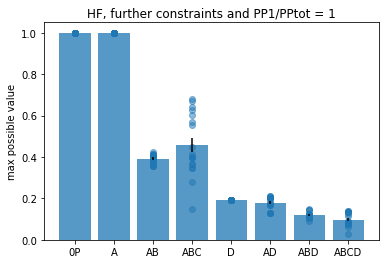

In [20]:
# plot

#optResult_HF_PP1fix = np.load('optResult_HF_PP1fixed.npy')

y = []
for i in range(8):
    y.append(optResult_HF_PP1fix[:,:,i,:,0].flatten())

plt.bar(np.asarray(range(8)), np.mean(np.asarray(y),axis=1),yerr=np.std(np.asarray(y),axis=1)/np.sqrt(nparamsets),alpha=0.75)
    
for i in range(8):
    plt.scatter(i*np.ones(len(y[i])),y[i],color='C0',alpha=0.5);
plt.xticks(np.asarray(range(8)),['0P','A','AB','ABC','D','AD','ABD','ABCD']);
plt.ylabel('max possible value');
plt.title('HF, further constraints and PP1/PPtot = 1');

## Heart failure conditions - further constraints and PP2A/PPtot = 1

In [21]:
# Vector for max PKA concentrations to be tested
vPKA = [donorValues[0]*f1*f2]
# Vector for total PPase concentrations to be tested
vPPase = [hfValues[3]]

optResult = []

for i in vPKA:
    for ii in vPPase:   
        
        maxValEnzymes = [i, 2e-7*f3, 2e-7*f3,0]    #pka_max, rsk2_max, pkc_ma, pp1_max
        minValEnzymes = [0,0,0,0]   #pka_min, rsk2_min, pkc_min, pp1_min
        startValEnzymes = [1e-9,1e-9,1e-9,0]  #pka_start, rsk2_start, pkc_start, pp1_start 
        
        #runOptimization(paramset,pNames,emax,emin,estart,PPtot, n_s, check=False):
        optResult.append(runOptimization(paramset[:nparamsets,:],paramNames,maxValEnzymes,minValEnzymes,startValEnzymes,ii,reps))
        
# optResult dimensions are PKA_max, PPase_tot, Phosphostate, Nr Paramsets, Repetition, Solution vector [optVal,PKA,PKC,RSK2,PP1,PPtot]    

# pick best of reps
dims = (len(vPKA),len(vPPase),8,nparamsets,reps,6)
newdims = (len(vPKA),len(vPPase),8,nparamsets,6)
optResult_HF_PP2Afix = bestRep(optResult,dims,newdims)

100%|██████████| 8/8 [36:29<00:00, 273.66s/it]


In [22]:
np.save('optResult_HF_PP2Afixed_tQSSA_'+str(np.format_float_scientific(cMyBPC_tot, unique=False, precision=2))+'.npy',optResult_HF_PP2Afix)

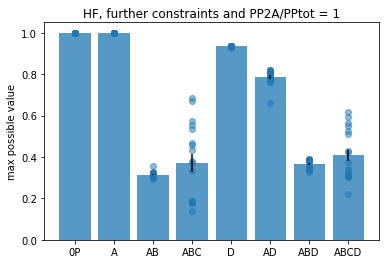

In [23]:
# plot

#optResult_HF_PP2Afix = np.load('optResult_HF_PP2Afixed.npy')

y = []
for i in range(8):
    y.append(optResult_HF_PP2Afix[:,:,i,:,0].flatten())

plt.bar(np.asarray(range(8)), np.mean(np.asarray(y),axis=1),yerr=np.std(np.asarray(y),axis=1)/np.sqrt(nparamsets),alpha=0.75)
    
for i in range(8):
    plt.scatter(i*np.ones(len(y[i])),y[i],color='C0',alpha=0.5);
plt.xticks(np.asarray(range(8)),['0P','A','AB','ABC','D','AD','ABD','ABCD']);
plt.ylabel('max possible value');
plt.title('HF, further constraints and PP2A/PPtot = 1');

## Heart failure conditions - further constraints and free PP1/PP2A ratio

In [24]:
# Vector for max PKA concentrations to be tested
vPKA = [donorValues[0]*f1*f2]
# Vector for total PPase concentrations to be tested
vPPase = [hfValues[3]]

optResult = []

for i in vPKA:
    for ii in vPPase:   
        
        maxValEnzymes = [i, 2e-7*f3, 2e-7*f3,ii]    #pka_max, rsk2_max, pkc_ma, pp1_max
        minValEnzymes = [0,0,0,0]   #pka_min, rsk2_min, pkc_min, pp1_min
        startValEnzymes = [1e-9,1e-9,1e-9,1e-9]  #pka_start, rsk2_start, pkc_start, pp1_start 

        #runOptimization(paramset,pNames,emax,emin,estart,PPtot, n_s, check=False):
        optResult.append(runOptimization(paramset[:nparamsets,:],paramNames,maxValEnzymes,minValEnzymes,startValEnzymes,ii,reps))
        
# optResult dimensions are PKA_max, PPase_tot, Phosphostate, Nr Paramsets, Repetition, Solution vector [optVal,PKA,PKC,RSK2,PP1,PPtot]    

# pick best of reps
dims = (len(vPKA),len(vPPase),8,nparamsets,reps,6)
newdims = (len(vPKA),len(vPPase),8,nparamsets,6)
optResult_HF_PPasesFree = bestRep(optResult,dims,newdims)

100%|██████████| 8/8 [41:27<00:00, 310.98s/it]


In [25]:
np.save('optResult_HF_PPasesFree_tQSSA_'+str(np.format_float_scientific(cMyBPC_tot, unique=False, precision=2))+'.npy',optResult_HF_PPasesFree)

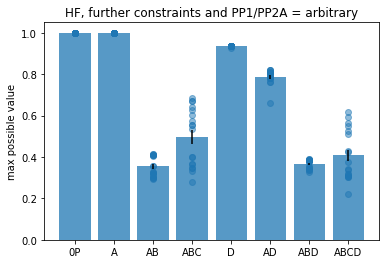

In [26]:
# plot

#optResult_HF_PPasesFree = np.load('optResult_HF_PPasesFree.npy')

y = []
for i in range(8):
    y.append(optResult_HF_PPasesFree[:,:,i,:,0].flatten())

plt.bar(np.asarray(range(8)), np.mean(np.asarray(y),axis=1),yerr=np.std(np.asarray(y),axis=1)/np.sqrt(nparamsets),alpha=0.75)
    
for i in range(8):
    plt.scatter(i*np.ones(len(y[i])),y[i],color='C0',alpha=0.5);
plt.xticks(np.asarray(range(8)),['0P','A','AB','ABC','D','AD','ABD','ABCD']);
plt.ylabel('max possible value');
plt.title('HF, further constraints and PP1/PP2A = arbitrary');

## No RSK2

In [27]:
# Vector for max PKA concentrations to be tested
vPKA = [donorValues[0]*f1]
# Vector for total PPase concentrations to be tested
vPPase = [donorValues[3]]


optResult = []

for i in vPKA:
    for ii in vPPase:   
        
        maxValEnzymes = [i, 0, 2e-7, ii]    #pka_max, rsk2_max, pkc_ma, pp1_max
        minValEnzymes = [0,0,0,0]   #pka_min, rsk2_min, pkc_min, pp1_min
        startValEnzymes = [1e-9,0,1e-9,1e-9]  #pka_start, rsk2_start, pkc_start, pp1_start 
        
        #runOptimization(paramset,pNames,emax,emin,estart,PPtot, n_s, check=False):
        optResult.append(runOptimization(paramset[:nparamsets,:],paramNames,maxValEnzymes,minValEnzymes,startValEnzymes,ii,reps))
        
# optResult dimensions are PKA_max, PPase_tot, Phosphostate, Nr Paramsets, Repetition, Solution vector [optVal,PKA,PKC,RSK2,PP1,PPtot]    

# pick best of reps
dims = (len(vPKA),len(vPPase),8,nparamsets,reps,6)
newdims = (len(vPKA),len(vPPase),8,nparamsets,6)
optResult_noRSK2 = bestRep(optResult,dims,newdims)

100%|██████████| 8/8 [58:19<00:00, 437.46s/it]


In [28]:
np.save('optResult_noRSK2_tQSSA_'+str(np.format_float_scientific(cMyBPC_tot, unique=False, precision=2))+'.npy',optResult_noRSK2)

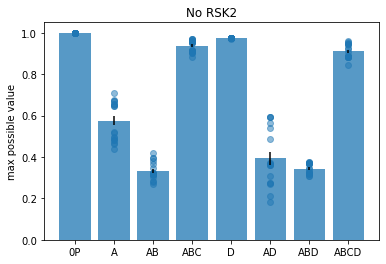

In [29]:
# plot

y = []
for i in range(8):
    y.append(optResult_noRSK2[:,:,i,:,0].flatten())

plt.bar(np.asarray(range(8)), np.mean(np.asarray(y),axis=1),yerr=np.std(np.asarray(y),axis=1)/np.sqrt(nparamsets),alpha=0.75)
    
for i in range(8):
    plt.scatter(i*np.ones(len(y[i])),y[i],color='C0',alpha=0.5);
plt.xticks(np.asarray(range(8)),['0P','A','AB','ABC','D','AD','ABD','ABCD']);
plt.ylabel('max possible value');
plt.title('No RSK2');